MMTC Dataset

In [ ]:
import csv
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
core_files = {
    '1x_1x': '/home/iiitd/Aditya/Plot_RoccaS/Symmetric_Cores/Mmtc_12G/rocca_1x_1x/round_robin_rocca_1x_6x/order_queue_round_robin_rocca_11_12_old.csv',
    '3x_3x': '/home/iiitd/Aditya/Plot_RoccaS/Symmetric_Cores/Mmtc_12G/rocca_3x_3x/round_robin_rocca_1x_6x/order_queue_round_robin_rocca_11_12_old.csv',
    '6x_6x': '/home/iiitd/Aditya/Plot_RoccaS/Symmetric_Cores/Mmtc_12G/rocca_6x_6x /round_robin_rocca_1x_6x/order_queue_round_robin_rocca_11_12_old.csv',
    '3x_6x_cs': '/home/iiitd/Aditya/Plot_RoccaS/Asymmetric_Cores/Mmtc-Dataset_12G/rocca_3x_6x/classifier_scheduler_rocca_1x_6x/order_queue_classifier_scheduler_rocca_11_14.csv',
    '3x_6x_amp': '/home/iiitd/Aditya/Plot_RoccaS/Asymmetric_Cores/Mmtc_Dataset_updated_12G/rocca_3x_6x/amp_load_balancer/output_1us_256.csv', 
}

core_ge = {
    '1x_1x': 407520.00,
    '3x_3x': 483420.00,
    '6x_6x': 618568.00,
    '1x_6x': 513044.00,
    '3x_6x': 550994.00,
}

core_watt = {
    '1x_1x': 5.239,
    '3x_3x': 5.600,
    '6x_6x': 5.900,
    '1x_6x': 5.553,
    '3x_6x': 5.750,
}

# core_ge = {
#     '1x_1x': 1409418.00,
#     '2x_2x': 2001608.00,
#     '4x_4x': 2806060.00,
#     '1x_2x': 1705946.00,
#     '1x_4x': 2102176.00,
# }

# core_watt = {
#     '1x_1x': 5.87,
#     '2x_2x': 7.81,
#     '4x_4x': 14.16,
#     '1x_2x': 7.49,
#     '1x_4x': 10.08,
# }

results_ge = []
results_watt = []
def remove_idle_time(csv_path):

    df = pd.read_csv(file_path)
    idle_time=0.0
    previous_processing_time = df['Processing Time'].iloc[0]
    # print("Previous processing time :", previous_processing_time)
    for index, row in df.iterrows():
            
        if index>0: # index 0 : 1st packet, index 1 : 2nd packet
            idle_duration = row['Relative Time'] - previous_processing_time
            if idle_duration >0:
                idle_time+=idle_duration
                # print("Idle duration :", idle_time)
            previous_processing_time = row['Processing Time']
    
    return idle_time
        

# Process data
for core_config, file_path in core_files.items():
    try:
        df = pd.read_csv(file_path)
        
        total_bits = (df['Length'] * 8).sum()
        start_time = df['Relative Time'].min()
        end_time = df['Processing Time'].max()
        duration = (end_time - start_time) / 1_000_000
        
        idle_time = remove_idle_time(file_path)
        # Convert idle time (us) to seconds
        idle_time = idle_time/1000_000

        # print("Idle time :", idle_time)
        # print("Duration before :", duration)
        duration = duration - idle_time  ## Remove the idle time from the dataset
        # print("Duration after :" ,duration)

        throughput_bps = total_bits / duration if duration > 0 else 0
        throughput_kbps = throughput_bps / 1_000
        throughput_gbps = throughput_bps / 1_000_000_000
        throughput_mbps = throughput_bps / 1_000_000

        print("Core config :",core_config,"Throughput :",throughput_gbps)
        
        ge_key = core_config[:5]
        if ge_key in core_ge:
            ge = core_ge[ge_key]
            throughput_per_ge_kbps = throughput_kbps / ge
            print("Throughput/ge kbps :", throughput_per_ge_kbps)
            results_ge.append((core_config, throughput_gbps, throughput_per_ge_kbps))
        
        power_key = core_config[:5]
        if power_key in core_watt:
            watt = core_watt[power_key]
            # throughput_per_watt_kbps = throughput_kbps / watt
            # results_watt.append((core_config, throughput_kbps, throughput_per_watt_kbps))
            # throughput_per_watt_gbps = throughput_gbps / watt
            throughput_per_watt_mbps = throughput_mbps / watt
            results_watt.append((core_config, throughput_kbps, throughput_per_watt_mbps))
            
    except Exception as e:
        print(f"Error processing {core_config}: {e}")

def packet_latency(df):

    # Calculate packet latency
    # df['processing_delay'] = df['Processing Time'] - df['Relative Time'] # microseconds
    df['processing_delay'] = (df['Processing Time'] - df['Relative Time'])/1000 # milliseconds
    delay = df['processing_delay']
    stats = {
        'min_ms': delay.min(),
        'mean_ms': delay.mean(),
        'max_ms': delay.max(),
        'median_ms': delay.median(),
        'p99_ms': delay.quantile(0.99)
    }
    return df[['processing_delay']],stats  # Return only the relevant column


# Convert to DataFrame
results_df_ge = pd.DataFrame(results_ge, columns=['Core Configuration', 'Throughput (Gbps)', 'Throughput per GE (Kbps)'])
results_df_watt = pd.DataFrame(results_watt, columns=['Core Configuration', 'Throughput (Gbps)', 'Throughput per Watt (Mbps)'])

throughput_ge_dict = dict(zip(results_df_ge['Core Configuration'], results_df_ge['Throughput per GE (Kbps)']))
throughput_watt_dict = dict(zip(results_df_watt['Core Configuration'], results_df_watt['Throughput per Watt (Mbps)']))

print("Throughput per ge dictionary :",throughput_ge_dict)
print("Power efficiency :",throughput_watt_dict)



if __name__ == "__main__":
    
    # Updated labels for box plots (same as bar charts)
    config_to_label = {
        '(s,S)': r'$\mathbf(S,S)$',
        '(M,M)': r'$\mathbf(M,M)$',
        '(L,L)' : r'$\mathbf(L,L)$',
        '(S,L)' : r'$\mathbf(S,L)$',
        '(M,L)' : r'$\mathbf(M,L)$',
    }
        
        
    # Initialize data containers
    latency_data = []
    
    # Calculate packet latency for each core configuration.
    for core_config, file_path in core_files.items():
        try:
            print("Core Config :",core_config)
            df2 = pd.read_csv(file_path) # Compute latency
            
            # Calculate packet latency
            df2, latency_stats = packet_latency(df2) # Compute latency
            print("Latency stats of the Config :",latency_stats)
            
            df2['core_type'] = core_config  # Add core type column
            latency_data.append(df2)  # Append to list
            

            # Calculate Out of Order percentage.
            algo = core_config  # Extract algo from the filename

        except Exception as e:
            print(f"Error processing {core_config}: {e}")

    # Concatenate all results into a single DataFrame for packet latency
    combined_df = pd.concat(latency_data, ignore_index=True)
    print(combined_df)


Core config : 1x_1x Throughput : 3.7246252921141765
Throughput/ge kbps : 9.139736189915038
Core config : 3x_3x Throughput : 5.1887863619918555
Throughput/ge kbps : 10.733495432526283
Core config : 6x_6x Throughput : 6.039423624773208
Throughput/ge kbps : 9.763556512417725
Core config : 3x_6x_cs Throughput : 5.9375872597539665
Throughput/ge kbps : 10.776137779638193
Core config : 3x_6x_amp Throughput : 5.7387469272964085
Throughput/ge kbps : 10.415262103210576
Throughput per ge dictionary : {'1x_1x': 9.139736189915038, '3x_3x': 10.733495432526283, '6x_6x': 9.763556512417725, '3x_6x_cs': 10.776137779638193, '3x_6x_amp': 10.415262103210576}
Power efficiency : {'1x_1x': 710.9420294167162, '3x_3x': 926.5689932128314, '6x_6x': 1023.6311228429165, '3x_6x_cs': 1032.6238712615593, '3x_6x_amp': 998.0429438776364}
Core Config : 1x_1x
Latency stats of the Config : {'min_ms': 0.0023548619709908964, 'mean_ms': 1184.2516070929198, 'max_ms': 2135.0132351624557, 'median_ms': 1211.190856218083, 'p99_ms'

Script for Running MMTC Final

Copy of MMTC Dataset

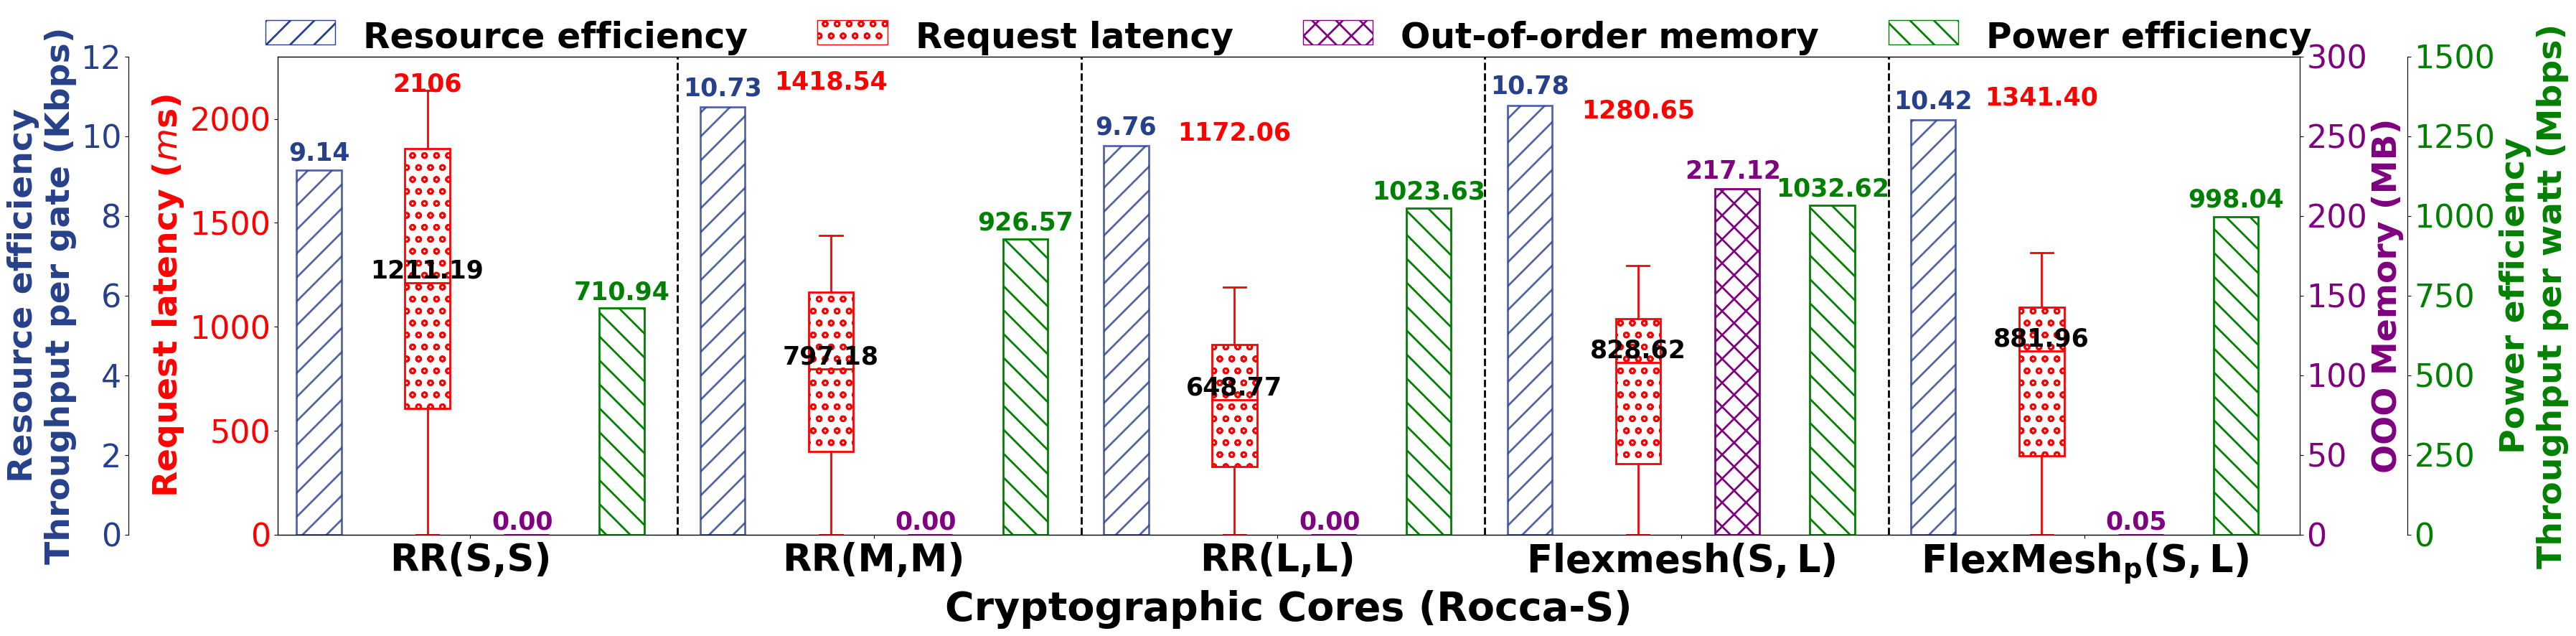

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

# ===================== DATA =====================
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 2

ooo_memory = {
    '1x_1x' : 0,
    '3x_3x' : 0,
    '6x_6x' : 0 ,
    '3x_6x_cs': 217122072.0,
    '3x_6x_amp' : 53896,
}
core_types = [
    '1x_1x',
    '3x_3x',
    '6x_6x',
    "3x_6x_cs",
    '3x_6x_amp'
]

label_map = {
    '1x_1x': 'RR(S,S)',
    '3x_3x': 'RR(M,M)',
    '6x_6x': 'RR(L,L)',
    # '1x_6x_flexmesh_workconserving': r'$\mathbf{Flexmesh(S,L)}$',
    "3x_6x_cs" : r'$\mathbf{Flexmesh(S,L)}$',
    '3x_6x_amp': r'$\mathbf{FlexMesh_{p}(S,L)}$',
}

# ===================== METRIC COLORS =====================

metric_colors = {
    # "resource": "#064d83",     # Throughput / gate
     "resource":  "#27408B",     # Throughput / gate
    "power": "green",       # Throughput / watt
    # "latency": "#cc5500",       # Request latency
    "latency": "red",       # Re
    "ooo": "purple"         # OOO memory
}

# ===================== LAYOUT =====================

bar_width = 12
latency_offset = 5
# INCREASED SPACING: Changed multiplier from 7 to 12 to add more space between groups
x = np.array([i * (4 * bar_width + 12 * latency_offset) for i in range(len(core_types))])

# Increased figure width from 30 to 40 to accommodate wider spacing
fig, ax1 = plt.subplots(figsize=(36, 9))
# fig, ax1 = plt.subplots()

# ===================== AXES =====================

ax_left2 = ax1

ax_left1 = ax1.twinx()
ax_left1.spines["left"].set_position(("outward", 150))
ax_left1.yaxis.set_label_position("left")
ax_left1.yaxis.set_ticks_position("left")
ax_left1.spines["right"].set_visible(False)

ax_right1 = ax1.twinx()
ax_right2 = ax1.twinx()
ax_right2.spines["right"].set_position(("outward", 108))

# ===================== RESOURCE EFFICIENCY =====================

for i, core in enumerate(core_types):
    val = throughput_ge_dict[core]
    ax_left1.bar(
        x[i] + latency_offset,
        val,
        width=bar_width,
        color=metric_colors["resource"],
        hatch='/',
        edgecolor=metric_colors["resource"],
        alpha=0.8,
        linewidth=2,
        align='edge',
        fill = False

    )
    ax_left1.text(
        x[i] + latency_offset + bar_width * 0.5,
        val + 0.015 * val,
        f'{val:.2f}',
        ha='center',
        va='bottom',
        fontsize=25,
        fontweight='bold',
        color=metric_colors["resource"]
    )

# ===================== POWER EFFICIENCY =====================

for i, core in enumerate(core_types):
    val = throughput_watt_dict[core]
    ax_right2.bar(
        x[i] + 5.5 * bar_width + 4 * latency_offset,
        val,
        width=bar_width,
        color=metric_colors["power"],
        hatch='\\',
        edgecolor=metric_colors["power"],
        alpha=1,
        linewidth=2,
        align='edge',
        fill = False
    )
    ax_right2.text(
        x[i] + 6 * bar_width + 4 * latency_offset,
        val + 0.014 * val,
        f'{val:.2f}',
        ha='center',
        va='bottom',
        fontsize=25,
        fontweight='bold',
        color=metric_colors["power"]
    )

# ===================== LATENCY BOXPLOTS =====================

latency_data = [
    combined_df[combined_df['core_type'] == core]['processing_delay']
    for core in core_types
]

box_latency = ax_left2.boxplot(
    latency_data,
    positions=[pos + 2.5 * bar_width + 2 * latency_offset for pos in x],
    widths=bar_width,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(
        # facecolor=metric_colors["latency"],
        facecolor = 'none',
        edgecolor=metric_colors["latency"],
        linewidth=2,
    ),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color=metric_colors["latency"], linewidth=2),
    capprops=dict(color=metric_colors["latency"], linewidth=2)
)

for patch in box_latency['boxes']:
    patch.set_hatch('o')

# ---- Annotate Median & P99 ----
for i, core in enumerate(core_types):
    lat_vals = combined_df[combined_df['core_type'] == core]['processing_delay']
    if len(lat_vals) > 0:
        median = lat_vals.median()
        p99 = np.percentile(lat_vals, 99)
        xpos = x[i] + 2.5 * bar_width + 2 * latency_offset

        if(i==0):
            ax_left2.text(
                xpos, median,
                f'{median:.2f}',
                ha='center',
                va='bottom',
                fontsize=25,
                fontweight='bold',
                color='black'
            )
            ax_left2.text(
                xpos, p99 + 0.6,
                f'{p99:.0f}',
                ha='center',
                va='bottom',
                fontsize=25,
                fontweight='bold',
                color=metric_colors["latency"]
            )

        # elif(i==2):
        #     ax_left2.text(
        #         xpos, median,
        #         f'{median:.2f}',
        #         ha='center',
        #         va='bottom',
        #         fontsize=25,
        #         fontweight='bold',
        #         color='black'
        #     )
        #     ax_left2.text(
        #         xpos, p99 + 500,
        #         f'{p99:.2f}',
        #         ha='center',
        #         va='bottom',
        #         fontsize=25,
        #         fontweight='bold',
        #         color=metric_colors["latency"]
        #     )
        else:

            ax_left2.text(
                xpos, median,
                f'{median:.2f}',
                ha='center',
                va='bottom',
                fontsize=25,
                fontweight='bold',
                color='black'
            )
            ax_left2.text(
                xpos, p99 + 700,
                f'{p99:.2f}',
                ha='center',
                va='bottom',
                fontsize=25,
                fontweight='bold',
                color=metric_colors["latency"]
            )

# ===================== OOO MEMORY =====================

for i, core in enumerate(core_types):
    mem_val = ooo_memory[core] / 1e6
    ax_right1.bar(
        x[i] + (4 * bar_width + 2.5 * latency_offset),
        mem_val,
        width=bar_width,
        # color=metric_colors["ooo"],
        hatch='x',
        edgecolor=metric_colors["ooo"],
        alpha=1,
        linewidth=2,
        align='edge',
        fill = False
    )
    ax_right1.text(
        x[i] + (4.2 * bar_width + 3 * latency_offset),
        mem_val + 0.015 * mem_val,
        f'{mem_val:.2f}',
        ha='center',
        va='bottom',
        fontsize=25,
        fontweight='bold',
        color=metric_colors["ooo"]
    )

# ===================== VERTICAL SEPARATORS =====================

for xpos in x:
    ax1.axvline(x=xpos-1, color='black', linestyle='--', linewidth=2)

# ===================== AXIS LABELS =====================

ax_left1.set_ylabel(
    'Resource efficiency\nThroughput per gate (Kbps)',
    fontsize=34, fontweight='bold', color=metric_colors["resource"]
)
ax_left2.set_ylabel(
    r"Request latency ($m$s)",
    # r'Request latency (ms)',
    fontsize=34, fontweight='bold', color=metric_colors["latency"]
)
ax_right1.set_ylabel(
    'OOO Memory (MB)',
    fontsize=34, fontweight='bold', color=metric_colors["ooo"]
)
ax_right2.set_ylabel(
    'Power efficiency\nThroughput per watt (Mbps)',
    fontsize=34, fontweight='bold', color=metric_colors["power"]
)

ax1.set_xlabel("Cryptographic Cores (Rocca-S)", fontsize=40, fontweight='bold')

# ===================== TICKS =====================

ax_left1.tick_params(axis='y', labelcolor=metric_colors["resource"], labelsize=32)
ax_left2.tick_params(axis='y', labelcolor=metric_colors["latency"], labelsize=32)
ax_right1.tick_params(axis='y', labelcolor=metric_colors["ooo"], labelsize=32)
ax_right2.tick_params(axis='y', labelcolor=metric_colors["power"], labelsize=32)

ax_left1.set_xticks(x + (2 * bar_width + 5.5 * latency_offset))
ax_left1.set_xticklabels([label_map[c] for c in core_types])
plt.setp(ax1.get_xticklabels(), fontsize=38, fontweight='bold')

ax_left1.set_xlim(x[0], x[-1] + 7 * bar_width + 5 * latency_offset)
ax_left2.set_ylim(0,2300)
ax_left1.set_ylim(0,12)
ax_right1.set_ylim(0,300)
ax_right2.set_ylim(0,1500)

# ax_left2.set_ylim(0,12)
# ax_left1.set_ylim(0,10)
# ax_right1.set_ylim(0,7)
# ax_right2.set_ylim(0,780)

# ===================== LEGEND =====================

class CenteredHandler(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent,
                       width, height, fontsize, trans):
        return [mpatches.Rectangle(
            (xdescent, ydescent + height / 7),
            width, height,
            facecolor=orig_handle.get_facecolor(),
            edgecolor=orig_handle.get_edgecolor(),
            hatch=orig_handle.get_hatch(),
            transform=trans
        )]

legend_elements = [
    mpatches.Patch(facecolor='white', edgecolor=metric_colors["resource"], hatch='/',
                   label='Resource efficiency',linewidth=4),
    mpatches.Patch(facecolor='white', edgecolor=metric_colors["latency"], hatch='o',
                   label='Request latency',linewidth=4),
    mpatches.Patch(facecolor='white', edgecolor=metric_colors["ooo"], hatch='x',
                   label='Out-of-order memory',linewidth=4),
    mpatches.Patch(facecolor='white', edgecolor=metric_colors["power"], hatch='\\',
                   label='Power efficiency',linewidth=4),
]

ax1.legend(
    handles=legend_elements,
    handler_map={mpatches.Patch: CenteredHandler()},
    loc='upper center',
    prop={'size': 35, 'weight': 'bold'},
    bbox_to_anchor=(0.5, 1.14),
    ncol=4,
    fontsize=25,
    frameon=False
)

# ===================== FINAL TOUCHES =====================

ax_left1.grid(False)
ax_left2.grid(False)
ax_right1.grid(False)
ax_right2.grid(False)

plt.tight_layout()
plt.savefig(
    "/home/iiitd/Aditya/Plot_RoccaS/scripts/Mmtc-Dataset-12G/plots_MMTC_RR/mmmtc_policies_updated_correct_ooo_script_update_2.pdf",
    bbox_inches="tight",
    pad_inches=0.4
)
plt.show()

GNB Dataset

In [83]:
import csv
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
core_files = {
    '1x_6x_cs' :  '/home/iiitd/Aditya/Plot_RoccaS/Asymmetric_Cores/gnb_mac_5g_Dataset_multiple_users/rocca_1x_6x/classifier_scheduler_rocca_1x_6x/order_queue_classifier_scheduler_rocca_11_14.csv',
    '1x_6x_amp' : '/home/iiitd/Aditya/Plot_RoccaS/Asymmetric_Cores/gnb_mac_5g_Dataset_multiple_users/rocca_1x_6x/amp_load_balancer_1x_6x/output_1us_256.csv',
}

core_ge = {
    '1x_1x': 407520.00,
    '3x_3x': 483420.00,
    '6x_6x': 618568.00,
    '1x_6x': 513044.00,
    '3x_6x': 550994.00,
}

core_watt = {
    '1x_1x': 5.239,
    '3x_3x': 5.600,
    '6x_6x': 5.900,
    '1x_6x': 5.553,
    '3x_6x': 5.750,
}

results_ge = []
results_watt = []

# Process data
for core_config, file_path in core_files.items():
    try:
        df = pd.read_csv(file_path)
        
        total_bits = (df['Length'] * 8).sum()
        start_time = df['Relative Time'].min()
        end_time = df['Processing Time'].max()
        duration = (end_time - start_time) / 1_000_000
        
        throughput_bps = total_bits / duration if duration > 0 else 0
        throughput_kbps = throughput_bps / 1_000
        throughput_gbps = throughput_bps / 1_000_000_000
        throughput_mbps = throughput_bps / 1_000_000
        
        ge_key = core_config[:5]
        if ge_key in core_ge:
            ge = core_ge[ge_key]
            throughput_per_ge_kbps = throughput_kbps / ge
            results_ge.append((core_config, throughput_gbps, throughput_per_ge_kbps))
        
        power_key = core_config[:5]
        if power_key in core_watt:
            watt = core_watt[power_key]
            # throughput_per_watt_kbps = throughput_kbps / watt
            # results_watt.append((core_config, throughput_kbps, throughput_per_watt_kbps))
            # throughput_per_watt_gbps = throughput_gbps / watt
            throughput_per_watt_mbps = throughput_mbps / watt
            results_watt.append((core_config, throughput_kbps, throughput_per_watt_mbps))
            
    except Exception as e:
        print(f"Error processing {core_config}: {e}")

def packet_latency(df):

    # Calculate packet latency
    # df['processing_delay'] = df['Processing Time'] - df['Relative Time'] # microseconds
    df['processing_delay'] = (df['Processing Time'] - df['Relative Time']) # milliseconds
    return df[['processing_delay']]  # Return only the relevant column


# Convert to DataFrame
results_df_ge = pd.DataFrame(results_ge, columns=['Core Configuration', 'Throughput (Gbps)', 'Throughput per GE (Kbps)'])
results_df_watt = pd.DataFrame(results_watt, columns=['Core Configuration', 'Throughput (Gbps)', 'Throughput per Watt (Mbps)'])

throughput_ge_dict = dict(zip(results_df_ge['Core Configuration'], results_df_ge['Throughput per GE (Kbps)']))
throughput_watt_dict = dict(zip(results_df_watt['Core Configuration'], results_df_watt['Throughput per Watt (Mbps)']))

print(throughput_ge_dict)



if __name__ == "__main__":
    
    # Updated labels for box plots (same as bar charts)
    config_to_label = {
        '(s,S)': r'$\mathbf(S,S)$',
        '(M,M)': r'$\mathbf(M,M)$',
        '(L,L)' : r'$\mathbf(L,L)$',
        '(S,L)' : r'$\mathbf(S,L)$',
        '(M,L)' : r'$\mathbf(M,L)$',
    }
        
        
    # Initialize data containers
    latency_data = []
    
    # Calculate packet latency for each core configuration.
    for core_config, file_path in core_files.items():
        try:
            print("Core Config :",core_config)
            df2 = pd.read_csv(file_path) # Compute latency
            
            # Calculate packet latency
            df2 = packet_latency(df2) # Compute latency
            
            df2['core_type'] = core_config  # Add core type column
            latency_data.append(df2)  # Append to list
            

            # Calculate Out of Order percentage.
            algo = core_config  # Extract algo from the filename

        except Exception as e:
            print(f"Error processing {core_config}: {e}")

    # Concatenate all results into a single DataFrame for packet latency
    combined_df = pd.concat(latency_data, ignore_index=True)
    print(combined_df)


{'1x_6x_cs': 0.16661343888353206, '1x_6x_amp': 0.16661343888353214}
Core Config : 1x_6x_cs
Core Config : 1x_6x_amp
         processing_delay  core_type
0                1.935852   1x_6x_cs
1                2.436727   1x_6x_cs
2                3.871705   1x_6x_cs
3                4.873454   1x_6x_cs
4                5.807557   1x_6x_cs
...                   ...        ...
3102323          1.978167  1x_6x_amp
3102324          1.978166  1x_6x_amp
3102325          1.978166  1x_6x_amp
3102326          2.024135  1x_6x_amp
3102327          2.397669  1x_6x_amp

[3102328 rows x 2 columns]


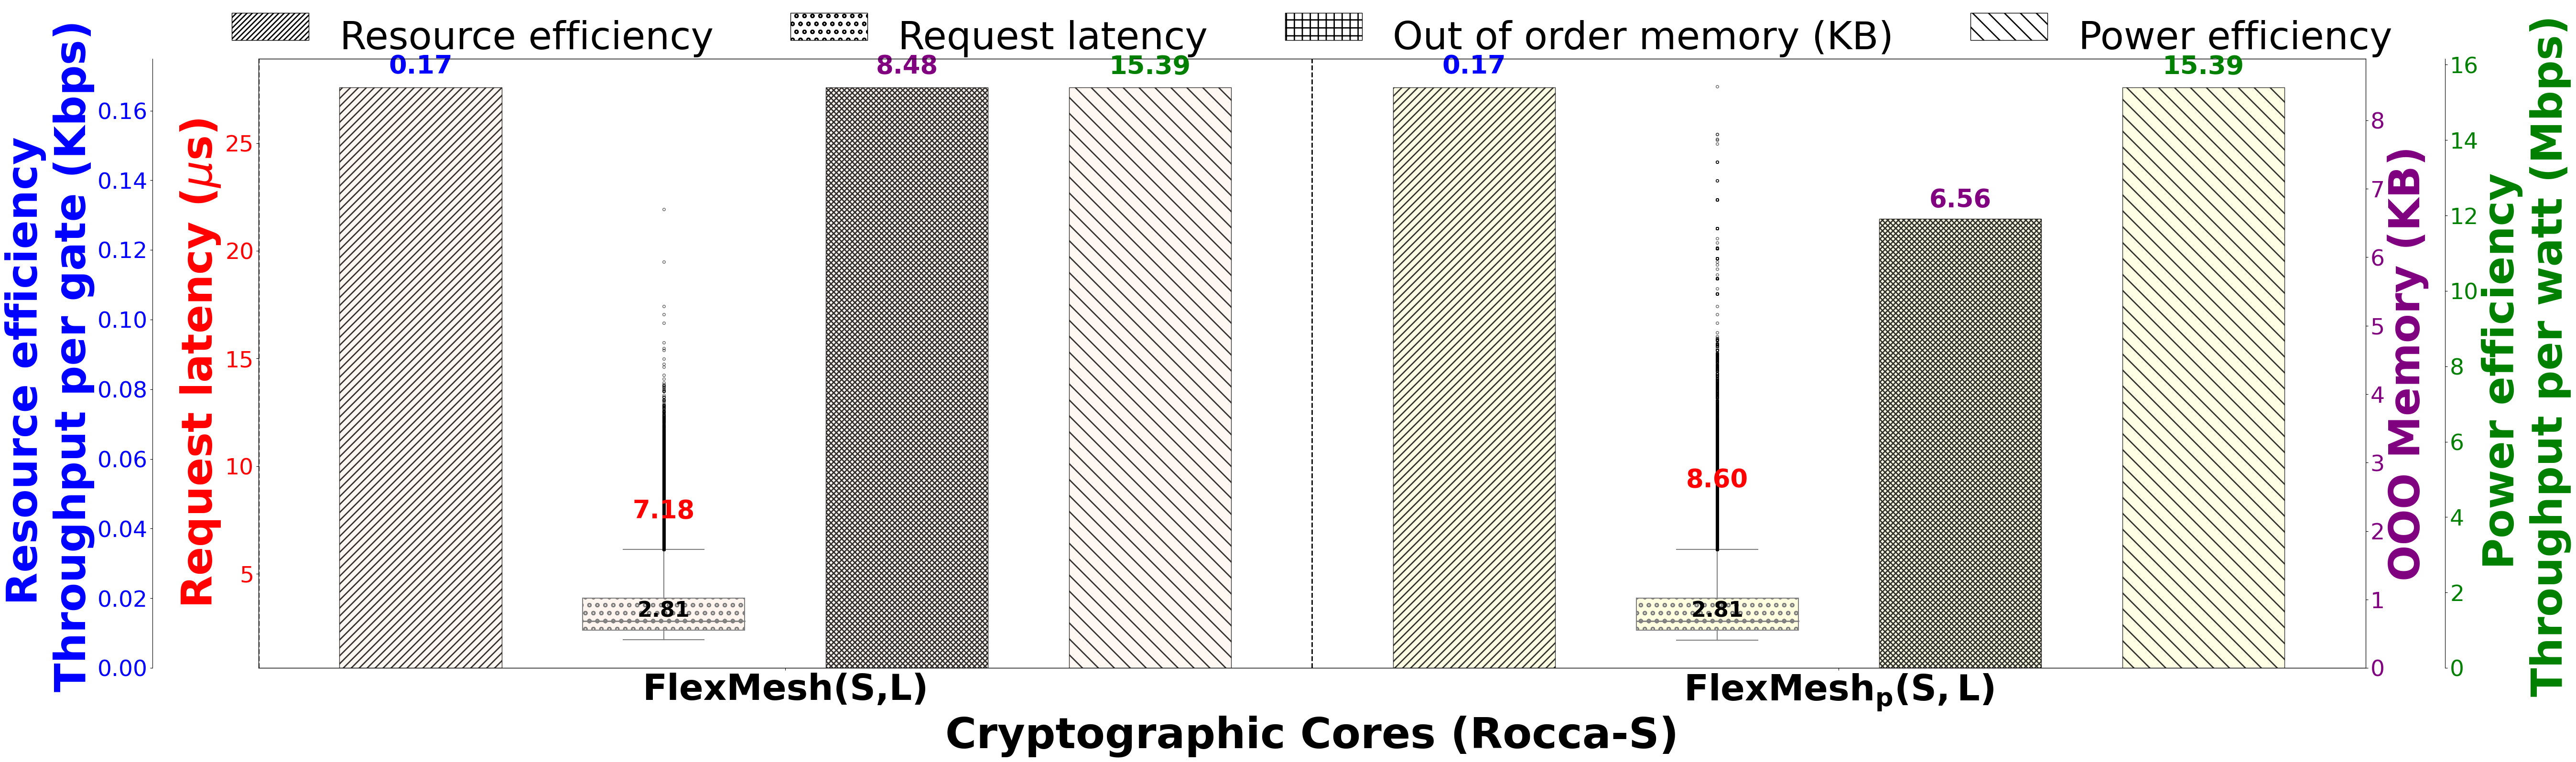

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# ooo_memory = {
#     '1x_1x' : 0,
#     '3x_3x' : 0,
#     '6x_6x' : 0 ,
#     '1x_6x_cs' :  91890132.0,
#     '3x_6x_cs': 125403624.0,
#     '1x_6x_amp': 126699200.0,
#     '3x_6x_amp': 111338472.0,
# }
ooo_memory = {
    # '3x_6x_cs': 217122072.0,
    # '3x_6x_amp': 15580,
    '1x_6x_cs' :  8479,
    '1x_6x_amp': 6559,
}

core_types = ['1x_6x_cs', '1x_6x_amp']
label_map = {
    # '1x_1x': 'RR(S,S)',
    # '3x_3x': 'RR(M,M)',
    # '6x_6x': 'RR(L,L)',
    # '1x_6x_rr': 'RR(S,L)',
    # '3x_6x_rr': 'RR(M,L)',
    # '3x_6x_cs': r'$\mathbf{Flexmesh(M,L)}$',
    # '3x_6x_amp': r'$\mathbf{FlexMesh_{p}(M,L)}$',
    '1x_6x_cs': 'FlexMesh(S,L)',
    '1x_6x_amp':r'$\mathbf{FlexMesh_{p}(S,L)}$',
}


# Increase spacing between groups - much wider spacing
bar_width = 2  # Slightly wider bars
latency_offset = 1
x = np.array([i * (4 * bar_width + 5 * latency_offset) for i in range(2)])  # consistent spacing with latency multiplier = 6


# colors = ['skyblue', 'salmon', 'limegreen', 'orange', 'violet']
colors = ['seashell', 'lightyellow',]  # Softer colors for better visibility
hatches = ['//', '\\', '---', '\\\///', '+++']

fig, ax1 = plt.subplots(figsize=(54, 16))  # Wider figure to accommodate spacing

# Updated Code

# === Left Y-axis 2 (closer to the plot) ===
ax_left2 = ax1
# ax_left2.set_ylabel('Metric 2 (Left Inner)', color='green')

# === Left Y-axis 1 (further out) ===
ax_left1 = ax1.twinx()
ax_left1.spines["left"].set_position(("outward", 160))
ax_left1.yaxis.set_label_position("left")
ax_left1.yaxis.set_ticks_position("left")
# ax_left1.set_ylabel('Metric 1 (Left Outer)', color='blue')

# Hide ax_left1's right spine (twinx adds it by default)
ax_left1.spines["right"].set_visible(False)

# === Right Y-axis 1 ===
ax_right1 = ax1.twinx()
# ax_right1.set_ylabel('Metric 3 (Right Inner)', color='red')

# === Right Y-axis 2 ===
ax_right2 = ax1.twinx()
ax_right2.spines["right"].set_position(("outward", 120))
# ax_right2.set_ylabel('Metric 4 (Right Outer)', color='purple')





# Bar plot: Throughput per GE (left position - more spacing)
bars_ge = []
for i, core in enumerate(core_types):
    val = throughput_ge_dict[core]
    bar = ax_left1.bar(x[i]+latency_offset, throughput_ge_dict[core], width=bar_width,
                  color=colors[i], hatch=hatches[0], edgecolor='black',
                  alpha=0.8, linewidth=1, label=f"{label_map[core]} - GE", align='edge')
    bars_ge.append(bar)
    ax_left1.text(x[i]+latency_offset + bar_width*0.5, val + 0.015 * val, f'{val:.2f}', 
             ha='center', va='bottom', fontsize=39, fontweight='bold', color='blue')

# Bar plot: Throughput per Watt (right position - more spacing)
bars_watt = []
for i, core in enumerate(core_types):
    val = throughput_watt_dict[core]
    bar = ax_right2.bar(x[i] + 3*bar_width + 4*latency_offset, throughput_watt_dict[core], width=bar_width,
                  color=colors[i], hatch=hatches[1], edgecolor='black',
                  alpha=0.8, linewidth=1, label=f"{label_map[core]} - Watt", align='edge')
    bars_watt.append(bar)
    ax_right2.text(x[i] + 3.5*bar_width + 4*latency_offset, val + 0.014 * val, f'{val:.2f}', 
             ha='center', va='bottom', fontsize=39, fontweight='bold', color='green')

# Box plot: Latency (center position)
latency_data = [combined_df[combined_df['core_type'] == core]['processing_delay'] for core in core_types]
# latency_offset = 0.7
box_latency = ax_left2.boxplot(latency_data, 
                #   positions= x,
                  positions=[pos +1.5*bar_width + 2*latency_offset for pos in x],
                  widths=bar_width,
                  patch_artist=True,
                  boxprops=dict(facecolor='white', color='black', linewidth=1.5),
                #   boxprops=dict(facecolor='none', edgecolor='g', hatch='xxx', linewidth=1.5),
                  medianprops=dict(color='grey', linewidth=2),
                  whiskerprops=dict(color='grey', linewidth=1.5),
                  capprops=dict(color='grey', linewidth=1.5),
                  flierprops=dict(marker='o', color='red', alpha=0.6, markersize=4))

# Box plot: OOO  (center position)
# ooo_data = [combined_ooo_df[combined_ooo_df['core_type'] == core]['Out of Order Percentage'] for core in core_types]
# ooo_offset = bar_width -0.2

# Custom boxplot colors/hatch
for i, patch in enumerate(box_latency['boxes']):
    patch.set_edgecolor('grey')  # Set edge color for the box
    patch.set_facecolor(colors[i])     # No face color fill
    # patch.set_hatch(hatches[i]) # Hatch pattern on edge
    patch.set_hatch('o')   
    patch.set_alpha(1.0)

          

# Annotate Median and P99 for latency values.
for i, core in enumerate(core_types):
    lat_vals = combined_df[combined_df['core_type'] == core]['processing_delay']
    if len(lat_vals) > 0:
        median = lat_vals.median()
        p99 = np.percentile(lat_vals, 99)
        xpos = x[i] +1.5*bar_width + 2*latency_offset # Center position for latency annotations
        ax_left2.text(xpos, median, f'{median:.2f}', ha='center', va='bottom',
                 fontsize=32, fontweight='bold', color='black')
        ax_left2.text(xpos, p99 + 0.02 * p99, f'{p99:.2f}', ha='center', va='bottom',
                 fontsize=38, color='red', fontweight='bold')
        
# Plot ooo memory bar plots on ax_right1
for i, core in enumerate(core_types):
    mem_val = ooo_memory[core]/ 1e3  # Convert bytes to kilobytes
    # Give same pattern as ooo box plot
    
    bar = ax_right1.bar(x[i] + (2*bar_width + 3*latency_offset), mem_val, width=bar_width ,
                  color=colors[i], hatch='xxx', edgecolor='black',
                  alpha=0.8, linewidth=1, label=f"{label_map[core]} - OOO Memory", align='edge')
    ax_right1.text(x[i] + (2.5*bar_width + 3*latency_offset), mem_val + 0.015 * mem_val, f'{mem_val:.2f}', 
             ha='center', va='bottom', fontsize=38, fontweight='bold', color='purple')


for xpos in x:
    # ax1.axvline(x=xpos-0.25*bar_width, color='black', linestyle='--', linewidth=2, alpha=1)
    ax1.axvline(x=xpos, color='black', linestyle='--', linewidth=2, alpha=1)

# Axis Labels
ax_left1.set_ylabel('Resource efficiency \n Throughput per gate (Kbps)', fontsize=64, fontweight='bold', color='blue')
ax_left2.set_ylabel(r'Request latency ($\mu$s)', fontsize=64, fontweight='bold', color='red')
ax_right1.set_ylabel('OOO Memory (KB)', fontsize=64, fontweight='bold', color='purple')
ax_right2.set_ylabel('Power efficiency \n Throughput per watt (Mbps)', fontsize=64, fontweight='bold', color='green')

ax1.set_xlabel("Cryptographic Cores (Rocca-S)", fontsize = 64,fontweight='bold')

# Color-coded ticks
ax_left1.tick_params(axis='y', labelcolor='blue')
ax_left2.tick_params(axis='y', labelcolor='red')
ax_right1.tick_params(axis='y', labelcolor='purple')
ax_right2.tick_params(axis='y', labelcolor='green')

# ax_left1.set_xlabel("Cryptographic Cores (Rocca-S)", fontsize = 30,fontweight='bold')

# X-axis with better spacing
ax_left1.set_xticks(x + (2*bar_width + 2.5*latency_offset))
ax_left1.set_xticklabels([label_map[c] for c in core_types])

plt.setp(ax1.get_xticklabels(), fontsize=54, fontweight='bold')

ax_left1.set_xlim(x[0] , x[-1] + 4*bar_width + 5*latency_offset)


class CenteredHandler(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        center = mpatches.Rectangle(
            (xdescent, ydescent+height/3), width, height + 0.5 ,
            facecolor=orig_handle.get_facecolor(),
            edgecolor=orig_handle.get_edgecolor(),
            hatch=orig_handle.get_hatch(),
            transform=trans
        )
        return [center]


legend_elements = [
    mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Resource efficiency'),
    mpatches.Patch(facecolor='white', edgecolor='black', hatch='o', label='Request latency'),
    mpatches.Patch(facecolor='white', edgecolor='black', hatch='+', label='Out of order memory (KB)'),
    mpatches.Patch(facecolor='white', edgecolor='black', hatch='\\', label='Power efficiency'),
]

# Add legend
# ax1.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.12),
#            ncol=3, fontsize=16,  title_fontsize=13, frameon=False)
ax1.legend(handles=legend_elements,
           handler_map={mpatches.Patch: CenteredHandler()},
           loc='upper center', bbox_to_anchor=(0.5, 1.12),
           ncol=4, fontsize=58, frameon=False)

ax_left1.tick_params(axis='y', labelsize=34)
ax_left2.tick_params(axis='y', labelsize=34)
ax_right1.tick_params(axis='y', labelsize=34)
ax_right2.tick_params(axis='y', labelsize=34)


# Remove title and all grids as requested
# plt.title("Performance Comparison of Core Configurations", fontsize=14, fontweight='bold')
# ax_left1.set_xlim(x[0] - bar_width * 2.6, x[-1] + bar_width * 2.8)

# ax_left1.set_ylim(0, 85.0)  # Resource efficiency
# ax_left2.set_ylim(0, 2.0)  # Request latency
# ax_right1.set_ylim(0, 2.0)  # Power efficiency
# ax

ax_left1.grid(False)
ax_left2.grid(False)
ax_right1.grid(False)
ax_right2.grid(False)

# Remove legend as requested
# legend_labels = [f"{label_map[c]}" for c in core_types]
# custom_patches = [plt.Rectangle((0, 0), 1, 1, facecolor=colors[i], hatch=hatches[i], edgecolor='black') for i in range(len(core_types))]
# ax1.legend(custom_patches, legend_labels, title="Core Type", loc='upper left', fontsize=10, title_fontsize=11)

# Set x-axis limits to show all data clearly
# ax1.set_xlim(-1, 8)

# Layout
# plt.savefig("/home/iiitd/Aditya/Plot_RoccaS/scripts/Mmtc-Dataset-12G/plots_MMTC_RR/flexmesh_flexmeshp_gnb_only.png")
plt.tight_layout()
plt.show()

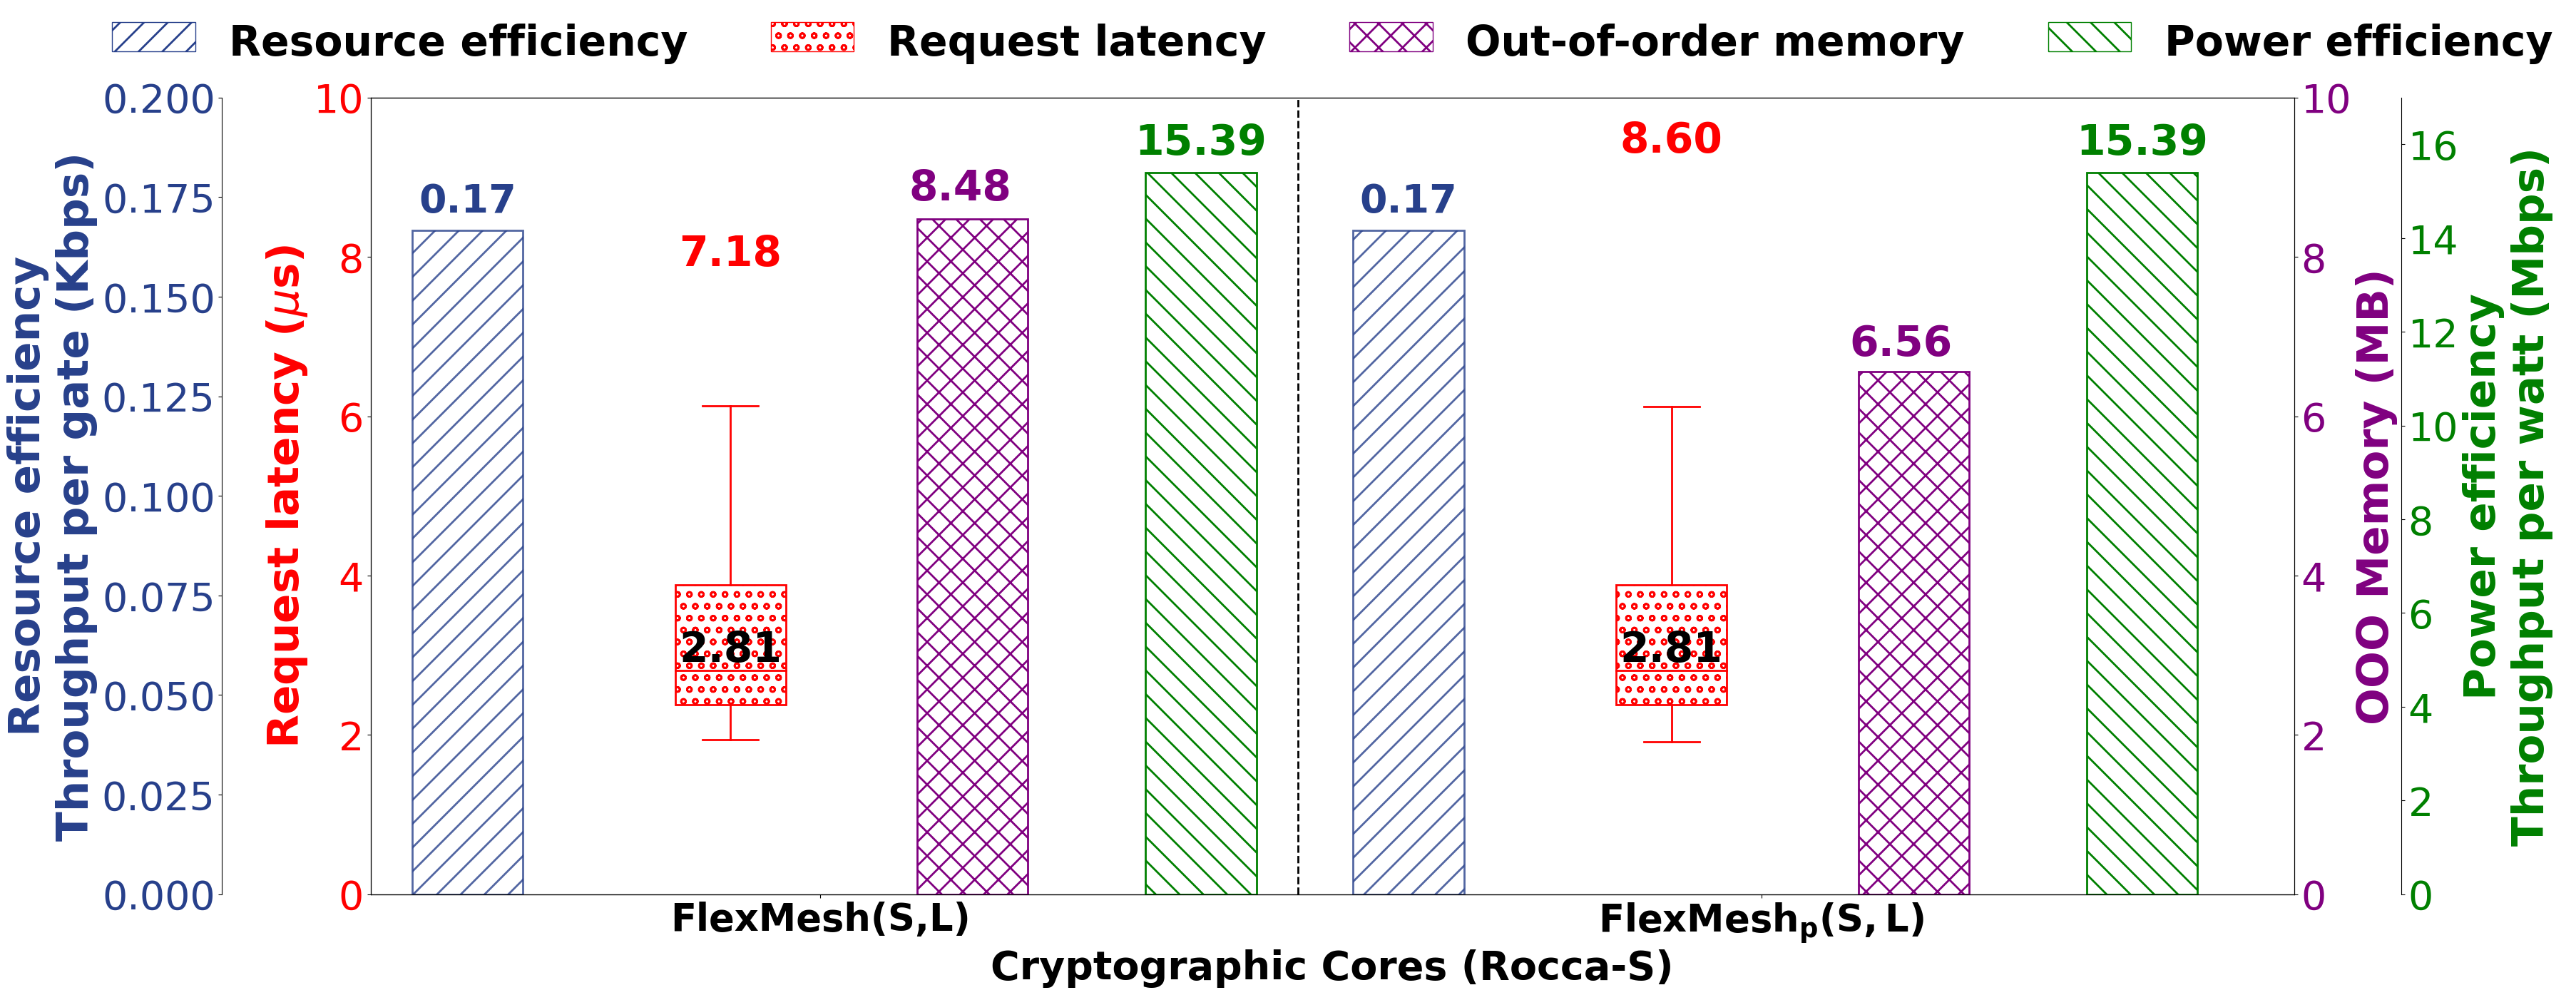

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

# ===================== DATA =====================
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 2

# ooo_memory = {
#     '1x_1x' : 0,
#     '3x_3x' : 0,
#     '6x_6x' : 0 ,
#     '3x_6x_cs': 217122072.0,
#     '3x_6x_amp' : 53896,
# }
# core_types = [
#     '1x_1x',
#     '3x_3x',
#     '6x_6x',
#     "3x_6x_cs",
#     '3x_6x_amp'
# ]

# label_map = {
#     '1x_1x': 'RR(S,S)',
#     '3x_3x': 'RR(M,M)',
#     '6x_6x': 'RR(L,L)',
#     # '1x_6x_flexmesh_workconserving': r'$\mathbf{Flexmesh(S,L)}$',
#     "3x_6x_cs" : r'$\mathbf{Flexmesh(S,L)}$',
#     '3x_6x_amp': r'$\mathbf{FlexMesh_{p}(S,L)}$',
# }

ooo_memory = {
    '1x_6x_cs' :  8479,
    '1x_6x_amp': 6559,
}

core_types = ['1x_6x_cs', '1x_6x_amp']
label_map = {
    '1x_6x_cs': 'FlexMesh(S,L)',
    '1x_6x_amp':r'$\mathbf{FlexMesh_{p}(S,L)}$',
}

# ===================== METRIC COLORS =====================

metric_colors = {
    # "resource": "#064d83",     # Throughput / gate
     "resource": "#27408B",     # Throughput / gate
    "power": "green",       # Throughput / watt
    # "latency": "#cc5500",       # Request latency
    "latency": "red",       # Re
    "ooo": "purple"         # OOO memory
}

# ===================== LAYOUT =====================

bar_width = 8
latency_offset = 3
# INCREASED SPACING: Changed multiplier from 7 to 12 to add more space between groups
x = np.array([i * (4 * bar_width + 12 * latency_offset) for i in range(len(core_types))])

# Increased figure width from 30 to 40 to accommodate wider spacing
fig, ax1 = plt.subplots(figsize=(26, 8))
# fig, ax1 = plt.subplots(figsize=(54, 16))  # Wider figure to accommodate spacing
# fig, ax1 = plt.subplots()

# ===================== AXES =====================

ax_left2 = ax1

ax_left1 = ax1.twinx()
ax_left1.spines["left"].set_position(("outward", 150))
ax_left1.yaxis.set_label_position("left")
ax_left1.yaxis.set_ticks_position("left")
ax_left1.spines["right"].set_visible(False)

ax_right1 = ax1.twinx()
ax_right2 = ax1.twinx()
ax_right2.spines["right"].set_position(("outward", 108))

# ===================== RESOURCE EFFICIENCY =====================

for i, core in enumerate(core_types):
    val = throughput_ge_dict[core]
    ax_left1.bar(
        x[i] + latency_offset,
        val,
        width=bar_width,
        color=metric_colors["resource"],
        hatch='/',
        edgecolor=metric_colors["resource"],
        alpha=0.8,
        linewidth=2,
        align='edge',
        fill = False

    )
    ax_left1.text(
        x[i] + latency_offset + bar_width * 0.5,
        val + 0.015 * val,
        f'{val:.2f}',
        ha='center',
        va='bottom',
        fontsize=40,
        fontweight='bold',
        color=metric_colors["resource"]
    )

# ===================== POWER EFFICIENCY =====================

for i, core in enumerate(core_types):
    val = throughput_watt_dict[core]
    ax_right2.bar(
        x[i] + 5.5 * bar_width + 4 * latency_offset,
        val,
        width=bar_width,
        color=metric_colors["power"],
        hatch='\\',
        edgecolor=metric_colors["power"],
        alpha=1,
        linewidth=2,
        align='edge',
        fill = False
    )
    ax_right2.text(
        x[i] + 6 * bar_width + 4 * latency_offset,
        val + 0.014 * val,
        f'{val:.2f}',
        ha='center',
        va='bottom',
        fontsize=42,
        fontweight='bold',
        color=metric_colors["power"]
    )

# ===================== LATENCY BOXPLOTS =====================

latency_data = [
    combined_df[combined_df['core_type'] == core]['processing_delay']
    for core in core_types
]

box_latency = ax_left2.boxplot(
    latency_data,
    positions=[pos + 2.5 * bar_width + 2 * latency_offset for pos in x],
    
    widths=bar_width,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(
        # facecolor=metric_colors["latency"],
        facecolor = 'none',
        edgecolor=metric_colors["latency"],
        linewidth=2,
    ),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color=metric_colors["latency"], linewidth=2),
    capprops=dict(color=metric_colors["latency"], linewidth=2)
)

for patch in box_latency['boxes']:
    patch.set_hatch('o')

# ---- Annotate Median & P99 ----
for i, core in enumerate(core_types):
    lat_vals = combined_df[combined_df['core_type'] == core]['processing_delay']
    if len(lat_vals) > 0:
        median = lat_vals.median()
        p99 = np.percentile(lat_vals, 99)
        xpos = x[i] + 2.5 * bar_width + 2 * latency_offset

        # if(i==0):
        ax_left2.text(
            xpos, median,
            f'{median:.2f}',
            ha='center',
            va='bottom',
            fontsize=42,
            fontweight='bold',
            color='black'
        )
        ax_left2.text(
            xpos, p99 + 0.6,
            f'{p99:.2f}',
            ha='center',
            va='bottom',
            fontsize=42,
            fontweight='bold',
            color=metric_colors["latency"]
        )

        # elif(i==2):
        #     ax_left2.text(
        #         xpos, median,
        #         f'{median:.2f}',
        #         ha='center',
        #         va='bottom',
        #         fontsize=42,
        #         fontweight='bold',
        #         color='black'
        #     )
        #     ax_left2.text(
        #         xpos, p99 + 500,
        #         f'{p99:.2f}',
        #         ha='center',
        #         va='bottom',
        #         fontsize=42,
        #         fontweight='bold',
        #         color=metric_colors["latency"]
        #     )
        # else:

            # ax_left2.text(
            #     xpos, median,
            #     f'{median:.2f}',
            #     ha='center',
            #     va='bottom',
            #     fontsize=42,
            #     fontweight='bold',
            #     color='black'
            # )
            # ax_left2.text(
            #     xpos, p99 + 700,
            #     f'{p99:.2f}',
            #     ha='center',
            #     va='bottom',
            #     fontsize=42,
            #     fontweight='bold',
            #     color=metric_colors["latency"]
            # )

# ===================== OOO MEMORY =====================

for i, core in enumerate(core_types):
    mem_val = ooo_memory[core] / 1e3
    ax_right1.bar(
        x[i] + (4 * bar_width + 2.5 * latency_offset),
        mem_val,
        width=bar_width,
        # color=metric_colors["ooo"],
        hatch='x',
        edgecolor=metric_colors["ooo"],
        alpha=1,
        linewidth=2,
        align='edge',
        fill = False
    )
    ax_right1.text(
        x[i] + (4.2 * bar_width + 3 * latency_offset),
        mem_val + 0.015 * mem_val,
        f'{mem_val:.2f}',
        ha='center',
        va='bottom',
        fontsize=42,
        fontweight='bold',
        color=metric_colors["ooo"]
    )

# ===================== VERTICAL SEPARATORS =====================

for xpos in x:
    ax1.axvline(x=xpos-1, color='black', linestyle='--', linewidth=2)

# ===================== AXIS LABELS =====================

ax_left1.set_ylabel(
    'Resource efficiency\nThroughput per gate (Kbps)',
    fontsize=44, fontweight='bold', color=metric_colors["resource"]
)
ax_left2.set_ylabel(
    r"Request latency ($\mu$s)",
    # r'Request latency (ms)',
    fontsize=44, fontweight='bold', color=metric_colors["latency"]
)
ax_right1.set_ylabel(
    'OOO Memory (MB)',
    fontsize=44, fontweight='bold', color=metric_colors["ooo"]
)
ax_right2.set_ylabel(
    'Power efficiency\nThroughput per watt (Mbps)',
    fontsize=44, fontweight='bold', color=metric_colors["power"]
)

ax1.set_xlabel("Cryptographic Cores (Rocca-S)", fontsize=40, fontweight='bold')

# ===================== TICKS =====================

ax_left1.tick_params(axis='y', labelcolor=metric_colors["resource"], labelsize=40)
ax_left2.tick_params(axis='y', labelcolor=metric_colors["latency"], labelsize=40)
ax_right1.tick_params(axis='y', labelcolor=metric_colors["ooo"], labelsize=40)
ax_right2.tick_params(axis='y', labelcolor=metric_colors["power"], labelsize=40)

ax_left1.set_xticks(x + (2 * bar_width + 5.5 * latency_offset))
ax_left1.set_xticklabels([label_map[c] for c in core_types])
plt.setp(ax1.get_xticklabels(), fontsize=38, fontweight='bold')

ax_left1.set_xlim(x[0], x[-1] + 7 * bar_width + 5 * latency_offset)
# ax_left2.set_ylim(0,2300)
ax_left1.set_ylim(0,0.20)
ax_right1.set_ylim(0,10)
ax_right2.set_ylim(0,17)
ax_left2.set_ylim(0, 10) 

# ax_left2.set_ylim(0,12)
# ax_left1.set_ylim(0,10)
# ax_right1.set_ylim(0,7)
# ax_right2.set_ylim(0,780)

# ===================== LEGEND =====================

class CenteredHandler(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent,
                       width, height, fontsize, trans):
        return [mpatches.Rectangle(
            (xdescent, ydescent + height / 7),
            width, height,
            facecolor=orig_handle.get_facecolor(),
            edgecolor=orig_handle.get_edgecolor(),
            hatch=orig_handle.get_hatch(),
            transform=trans
        )]

legend_elements = [
    mpatches.Patch(facecolor='white', edgecolor=metric_colors["resource"], hatch='/',
                   label='Resource efficiency',linewidth=4),
    mpatches.Patch(facecolor='white', edgecolor=metric_colors["latency"], hatch='o',
                   label='Request latency',linewidth=4),
    mpatches.Patch(facecolor='white', edgecolor=metric_colors["ooo"], hatch='x',
                   label='Out-of-order memory',linewidth=4),
    mpatches.Patch(facecolor='white', edgecolor=metric_colors["power"], hatch='\\',
                   label='Power efficiency',linewidth=4),
]

ax1.legend(
    handles=legend_elements,
    handler_map={mpatches.Patch: CenteredHandler()},
    loc='upper center',
    prop={'size': 42, 'weight': 'bold'},
    bbox_to_anchor=(0.5, 1.14),
    ncol=4,
    fontsize=38,
    frameon=False
)

# ===================== FINAL TOUCHES =====================

ax_left1.grid(False)
ax_left2.grid(False)
ax_right1.grid(False)
ax_right2.grid(False)

plt.tight_layout()
plt.savefig(
    "/home/iiitd/Aditya/Plot_RoccaS/scripts/Mmtc-Dataset-12G/plots_MMTC_RR/gnb_policies_updated_correct_ooo_script_update_2.pdf",
    bbox_inches="tight",
    pad_inches=0.4
)
plt.show()